# Fake News Detection 

```
Technical Project 2021-22
```
Submitted By:
> N051 - Rajshree Varma

> N053 - Yugandhara Verma

> N055 - Priya Vijayvargiya





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import re
import string
import urllib
import gzip
import time

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Flatten, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data collection

Getting real about fake news - A Kaggle Dataset :

FAKE NEWS Dataset - [link](https://https://www.kaggle.com/mrisdal/fake-news)

REAL NEWS Dataset - [link](https://www.kaggle.com/anthonyc1/gathering-real-news-for-oct-dec-2016/notebook)

In [ ]:
fake_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/fake.csv")
real_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/real.csv")

#size of the datasets
nRow, nCol = fake_news.shape
print(f'There are {nRow} rows and {nCol} columns in the Fake News Dataset')

nRow1, nCol1 = real_news.shape
print(f'There are {nRow1} rows and {nCol1} columns in the Real News Dataset')

There are 12999 rows and 20 columns in the Fake News Dataset
There are 15712 rows and 11 columns in the Real News Dataset


* The Fake News dataset has a more columns than the Real News dataset. Hence there will be a need to extract/concatenate columns in future to make a new dataset for training our DL model

In [ ]:
#columns
print('Column Names\n')
print('Fake News Dataset:\n', list(fake_news.columns))
print('\nReal News Dataset:\n', list(real_news.columns))

Column Names

Fake News Dataset:
 ['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score', 'main_img_url', 'replies_count', 'participants_count', 'likes', 'comments', 'shares', 'type']

Real News Dataset:
 ['Unnamed: 0', 'Unnamed: 0.1', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']


## Exploratory Data Analysis

### FAKE NEWS Dataset

**Column Description:**
* uuid = Unique identifier, 
* author = author of story, 
* published = date published, title => title of the story, 
* text = text of story, 
* language = data from webhose.io, 
* crawled = date the story was archived, 
* site_url = site URL from BS detector, 
* country = data from webhose.io, 
* domain_rank, thread_title, spam_score = data from webhose.io, 
* main_img_url = image from story, 
* replies_count = number of replies, 
* participants_count = number of participants, 
* likes = number of Facebook likes, 
* comments = number of Facebook comments, 
* shares = number of Facebook shares, 
* type = type of website (label from BS detector)

This dataset contains text and metadata scraped from 244 websites tagged as "bullshit" by the BS Detector Chrome Extension by Daniel Sieradski. Therefor majority of stories are tagged as "bs".

In [ ]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                12999 non-null  object 
 1   ord_in_thread       12999 non-null  int64  
 2   author              10575 non-null  object 
 3   published           12999 non-null  object 
 4   title               12319 non-null  object 
 5   text                12953 non-null  object 
 6   language            12999 non-null  object 
 7   crawled             12999 non-null  object 
 8   site_url            12999 non-null  object 
 9   country             12823 non-null  object 
 10  domain_rank         8776 non-null   float64
 11  thread_title        12987 non-null  object 
 12  spam_score          12999 non-null  float64
 13  main_img_url        9356 non-null   object 
 14  replies_count       12999 non-null  int64  
 15  participants_count  12999 non-null  int64  
 16  like

In [ ]:
#datatypes of all attributes in fake news dataset
fake_news.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
dtype: object

In [ ]:
#null values
fake_news.isnull().any()

uuid                  False
ord_in_thread         False
author                 True
published             False
title                  True
text                   True
language              False
crawled               False
site_url              False
country                True
domain_rank            True
thread_title           True
spam_score            False
main_img_url           True
replies_count         False
participants_count    False
likes                 False
comments              False
shares                False
type                  False
dtype: bool

* The columns having null values present: author, title, text, country, 
domain_rank, thread_title, main_img_url

In [ ]:
#Check for the null values
fake_news.isnull().sum()

uuid                     0
ord_in_thread            0
author                2424
published                0
title                  680
text                    46
language                 0
crawled                  0
site_url                 0
country                176
domain_rank           4223
thread_title            12
spam_score               0
main_img_url          3643
replies_count            0
participants_count       0
likes                    0
comments                 0
shares                   0
type                     0
dtype: int64

In [ ]:
#fake_news["domain_rank"].fillna(fake_news.domain_rank.median(axis=0),inplace=True)

In [ ]:
fake_news.describe()

,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares
count,12999.000000,8776.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000,12999.000000
mean,0.891530,38092.996582,0.026122,1.383183,1.727518,10.831833,0.038311,10.831833
std,6.486822,26825.487454,0.122889,9.656838,6.884239,79.798949,0.827335,79.798949
min,0.000000,486.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,17423.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,34478.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,60570.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,100.000000,98679.000000,1.000000,309.000000,240.000000,988.000000,65.000000,988.000000


Inference for columns: 'ord_in_thread', 'spam_score', 'replies_count', 'participants_count', 'likes', 'comments' and 'shares', we observe that :

*   Between the Max and Min values, more than 75% values are 0, hence they do not give an accurate desciption of any kind, that maybe useful for us to build our Deep Learning Model for now

* 'domain_rank' has a lot of null values, so it wont be helpful at this stage of the DL model


**Correlation Analysis:**

It gives us correlation between numerical features. Values are between -1 and 1. 

* Close to 0 means no connection about these two variable. 
* Close to +1 means positive correlation, so these two have direct proportion. 
* Close to -1 means negative correlation, so these two have indirect/inverse proportion.

In [ ]:
fake_news.corr()

,ord_in_thread,domain_rank,spam_score,replies_count,participants_count,likes,comments,shares
ord_in_thread,1.000000,-0.184794,-0.018859,0.830462,0.760739,-0.018657,-0.006365,-0.018657
domain_rank,-0.184794,1.000000,-0.027991,-0.174894,-0.177657,-0.201984,-0.076436,-0.201984
spam_score,-0.018859,-0.027991,1.000000,-0.007477,-0.019813,0.041199,-0.004444,0.041199
replies_count,0.830462,-0.174894,-0.007477,1.000000,0.971898,-0.019056,-0.006595,-0.019056
participants_count,0.760739,-0.177657,-0.019813,0.971898,1.000000,-0.020136,-0.008447,-0.020136
likes,-0.018657,-0.201984,0.041199,-0.019056,-0.020136,1.000000,0.158758,1.000000
comments,-0.006365,-0.076436,-0.004444,-0.006595,-0.008447,0.158758,1.000000,0.158758
shares,-0.018657,-0.201984,0.041199,-0.019056,-0.020136,1.000000,0.158758,1.000000


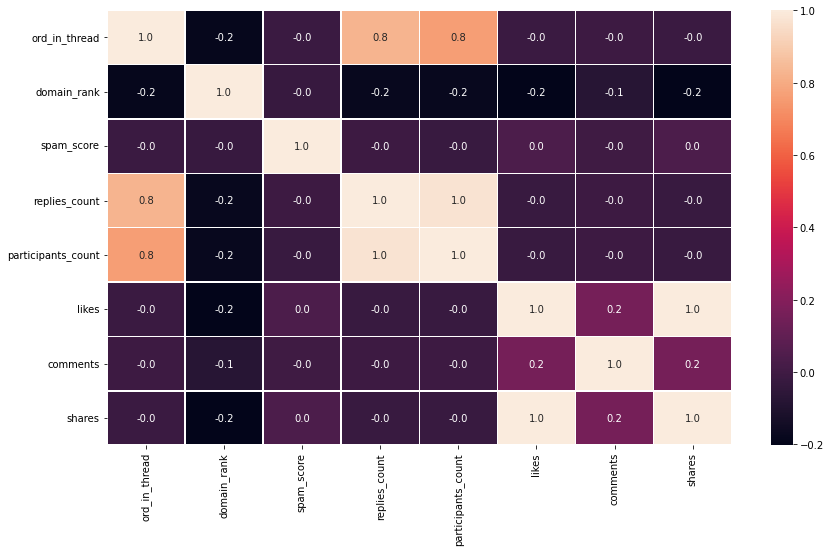

In [ ]:
#correlation heatmap
f,ax = plt.subplots(figsize=(14, 8))
sns.heatmap(fake_news.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

* There is strong direct correlation between participant_count & replies_count

* ord_in_thread is also strongly correlated to participant_count & replies_count

* Overall, there is no meaningful strong correlation between any of the features that will be helpful to build our DL model.


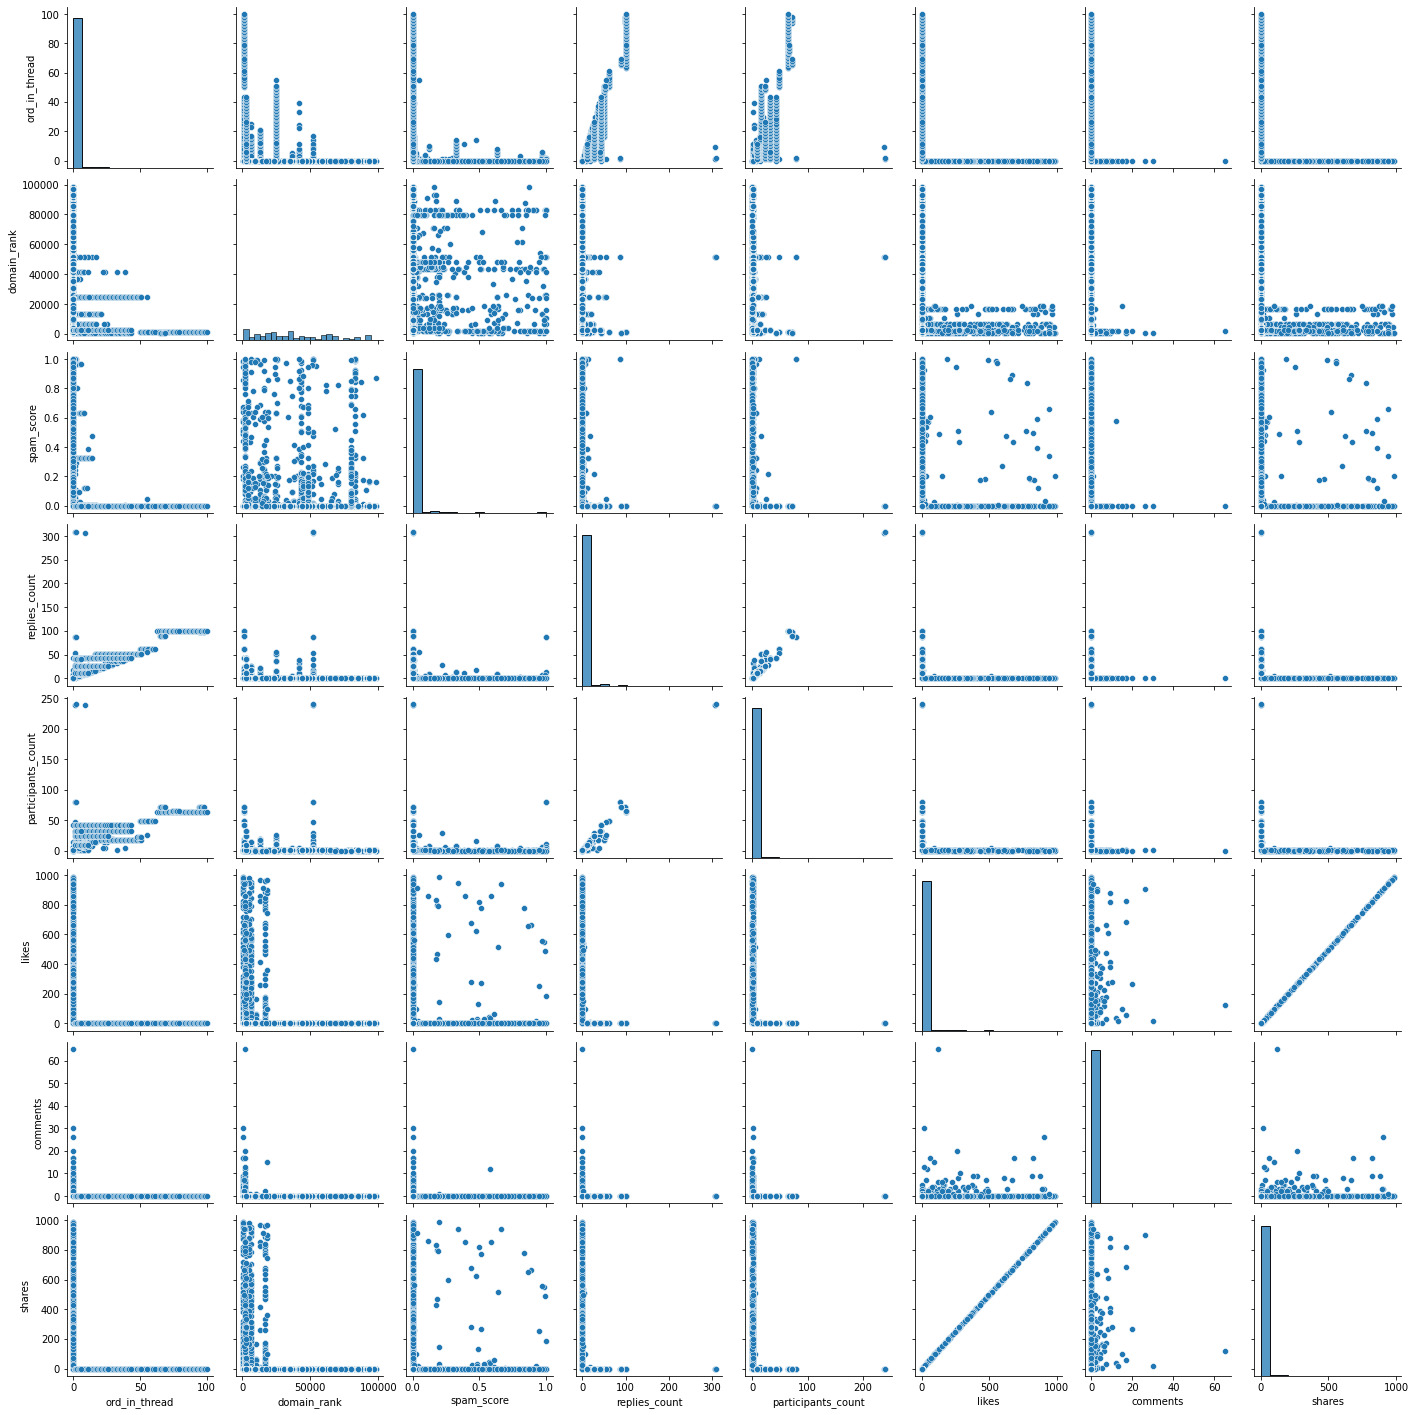

In [ ]:
sns.pairplot(fake_news)

* There is no clear inference here to indicate the key features of this dataset for our model.
* Likes and shares are highly positively correlated - which do not give an insight for the model, but it further indicates the critical nature of spread of Fake News in the society



> **Types of Fake News**



In [ ]:
#fake news types
print("Types and amount of stories present in the Fake News Dataset:", fake_news.groupby(["type"]).size())

Types and amount of stories present in the Fake News Dataset: type
bias            443
bs            11492
conspiracy      430
fake             19
hate            246
junksci         102
satire          146
state           121
dtype: int64


**FN Type Tags Description:**

There are 12999 rows and 20 columns in the Fake News Dataset, which contains text and metadata scraped from 244 websites tagged as "bullshit" (bs) by the BS Detector Chrome Extension by Daniel Sieradski. 

* Extreme Bias (bias) : Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts.

* Conspiracy Theory (conspiracy): Sources that are well-known promoters of kooky conspiracy theories.

* Fake News (fake) : Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports.

* Hate News (hate) : Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination.

* Junk Science (junksci) : Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

* Satire (satire) : Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events.

* State News (state) : Sources in biased and repressive states operating under government sanction.

* Rumor Mill (rumor) : Sources that traffic in rumors, gossip, innuendo, and unverified claims.

In [ ]:
#fake_news.groupby(['type']).size().plot(kind='barh')

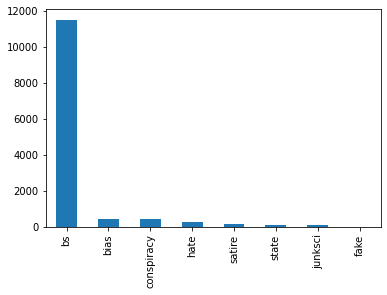

In [ ]:
fake_news.type.value_counts().plot(kind='bar')

* It is interesting for us to understand the nuances of all these different types of news stories - that can be clasfiied as fake. This can prove to be useful when more data gets added in the corpus



> **Language Detection:**



In [ ]:
#languages of fake news stories
languages=fake_news['language'].unique()
print("The Fake News Dataset contains stories in the following languages:\n",languages)
print("No. of stories present in these languages:", fake_news.groupby(["language"]).size())

The Fake News Dataset contains stories in the following languages:
 ['english' 'ignore' 'german' 'french' 'spanish' 'russian' 'greek'
 'finnish' 'portuguese' 'arabic' 'dutch' 'italian' 'turkish' 'norwegian'
 'chinese' 'polish']
No. of stories present in these languages: language
arabic           22
chinese           1
dutch             3
english       12403
finnish           1
french           38
german          111
greek             4
ignore            7
italian           9
norwegian         3
polish            1
portuguese       11
russian         203
spanish         172
turkish          10
dtype: int64


This dataset has all kinds language of news stories. 

* Given the fact that NLTK and AI techniques only majorly recognize English language stopwords, features etc. 
* Out of 12999 rows, 12403 i.e., a high majority of stories are written in English.
* Overall almost negligible amount of news are in any other languages worth training this DL model

There is a need to prune the dataset and keep only essential columns and English language articles

In [ ]:
# essential columns
fake_news1 = fake_news[['title', 'text','language','site_url']]
fake_news1 = fake_news1[fake_news1.language == 'english']
fake_news1['title'].fillna(value="", inplace=True)

# drop null 'text' rows as there is no context of the article
fake_news1.dropna(axis=0, inplace=True, subset=['text'])

# data shuffling and resetting index to avoid bias
fake_news1 = fake_news1.sample(frac=1.0) 
fake_news1.reset_index(drop=True,inplace=True)
fake_news1.head()

,title,text,language,site_url
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,english,activistpost.com
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,english,trunews.com
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",english,thenewamerican.com
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,english,thefreethoughtproject.com
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,english,activistpost.com


Based on the literature review, the studies on CoAID (COVID-19 heAlthcare mIsinformation Dataset), disasters, PolitiFact, gossipcop etc. we observed that these are the essential columns used in majority of the proposed models by researchers. 

In [ ]:
print(fake_news1.shape)

(12357, 4)


* Now, the no. of columns reduce from 12999 to 12357 rows and from 20 to 4 columns.

In [ ]:
fake_news1.isnull().any()

title       False
text        False
language    False
site_url    False
dtype: bool

* As a result, there are no longer null rows present in our dataset - better for trainign the model

### **REAL NEWS Dataset**

Build from reliable credible articles of sources like : 'New York Times', 'CNN','Atlantic','Fox News','Guardian','National Review','NPR','Reuters', 'Vox','Washington Post'

In [ ]:
real_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15712 entries, 0 to 15711
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    15712 non-null  int64  
 1   Unnamed: 0.1  15712 non-null  int64  
 2   id            15712 non-null  int64  
 3   title         15712 non-null  object 
 4   publication   15712 non-null  object 
 5   author        13967 non-null  object 
 6   date          15712 non-null  object 
 7   year          15712 non-null  float64
 8   month         15712 non-null  float64
 9   url           11101 non-null  object 
 10  content       15712 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.3+ MB


* The columns having null values present: author and url

In [ ]:
#datatypes of all attributes in real news dataset
#real_news.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
id                int64
title            object
publication      object
author           object
date             object
year            float64
month           float64
url              object
content          object
dtype: object

In [ ]:
#Check for the null values
real_news.isnull().sum()

Unnamed: 0         0
Unnamed: 0.1       0
id                 0
title              0
publication        0
author          1745
date               0
year               0
month              0
url             4611
content            0
dtype: int64

* Out of the total 15712 rows, the no. of null 'author' rows is almost negligible. But as long as there is the publication present, it should not pose a problem for our Fake news detection model
* 'url' is not really of significance here as we can easily find the articles through web scraping on the net
* Either ways, the no. of missing values is insignificant compared to the 15712 rows pressent in the dataset

In [ ]:
real_news.describe()

,Unnamed: 0,Unnamed: 0.1,id,year,month
count,15712.000000,15712.000000,15712.000000,15712.0,15712.000000
mean,20978.501846,91891.630664,136929.960412,2016.0,11.014766
std,14278.341806,43323.488154,63194.356338,0.0,0.813238
min,0.000000,0.000000,17283.000000,2016.0,10.000000
25%,6627.750000,59638.750000,81634.750000,2016.0,10.000000
50%,24302.500000,105508.000000,155836.000000,2016.0,11.000000
75%,31320.250000,128835.250000,193155.500000,2016.0,12.000000
max,49997.000000,146032.000000,218082.000000,2016.0,12.000000


* Almost all real values are from 2016, as most contributions have been made during that perios only amongst the community members
* The news articles span a period of 10-12 months time
* Unnamed: 0, Unnamed: 0.1 and id do not show nay significant inferesnce to extract features

**Correlation Analysis**

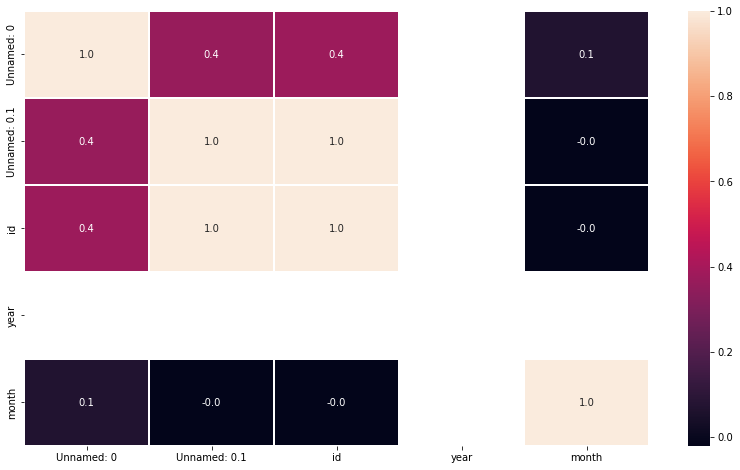

In [ ]:
#correlation heatmap
f,ax = plt.subplots(figsize=(14, 8))
sns.heatmap(real_news.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

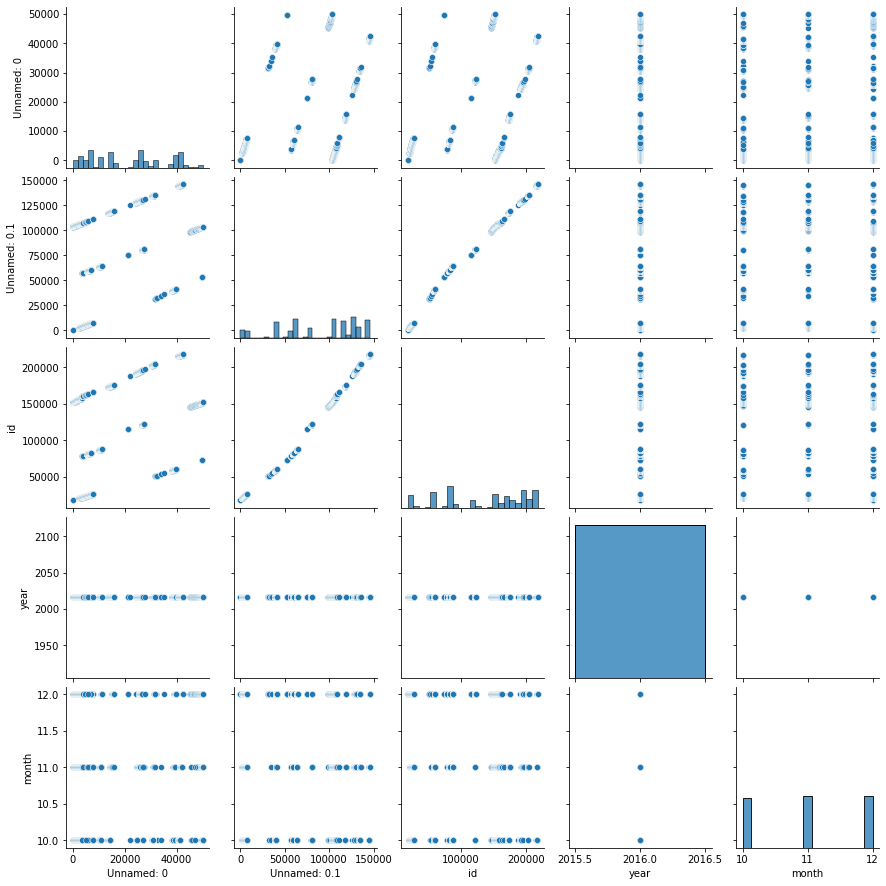

In [ ]:
sns.pairplot(real_news)

* There is no corrrleation between the number features for training the DL model

## Data Preprocessing

Similar features for both datasets:
* title of article
* content or text of article
* which company or website published the article

Publication: 

* Real news dataset has the publication company in the 'publication' column,  
* Fake news dataset has it as an url in the 'site_url' column.


We will have to parse the site_urls into publication names before we merge and Label data "real" for real news and "fake" for fake news

In [ ]:
#feature extraction
fake_news2 = fake_news1[['title', 'text','site_url']]

#data labelling
fake_news2['label'] = 'fake'
fake_news2.head()

,title,text,site_url,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost.com,fake
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews.com,fake
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican.com,fake
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject.com,fake
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost.com,fake


In [ ]:
#all site_urls
site_urls = fake_news2['site_url']

#removing domain extensions
site_urls2 = [x.split('.',1)[0] for x in site_urls]

#replacing the old site_url column with these values
fake_news2['site_url'] = site_urls2
fake_news2.head()

,title,text,site_url,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,fake
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,fake
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,fake
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,fake
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,fake


In [ ]:
#feature extraction
real_news2 = real_news[['title', 'content', 'publication']]

#data labelling
real_news2['label'] = 'real'
real_news2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


**Data Concatenation**

In [ ]:
#rename features in our final datasets
newlabels = ['title', 'content', 'publication', 'label']
real_news2.columns = newlabels
fake_news2.columns = newlabels

#dataframe combined to form a new final Fake News Detection dataset
dataframes = [fake_news2, real_news2]
final_dataset = pd.concat(dataframes)
final_dataset

,title,content,publication,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,fake
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,fake
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,fake
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,fake
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [ ]:
final_dataset.to_csv('final_dataset.csv', encoding='utf-8')

## Feature Engineering

In Feature Engineering - Text cleaning steps may vary based on the type of data and the required task. Generally, the string is converted to lowercase and punctuation is removed before text gets tokenized. 

**Exploratory Data Analysis of Final Dataset**

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 15711
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        28069 non-null  object
 1   content      28069 non-null  object
 2   publication  28069 non-null  object
 3   label        28069 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [ ]:
final_dataset.describe()

,title,content,publication,label
count,28069,28069,28069,28069
unique,26754,27538,245,2
top,,,Reuters,real
freq,680,106,2307,15712


* Reuters is the most common publication
* Although not all title maybe unique, the content under them is what matters the most, hence  we can prune these based on common values. Hence, the use of fillna() function 

In [ ]:
# Fill any null fields
final_dataset.title.fillna("", inplace=True)
final_dataset.content.fillna("", inplace=True)

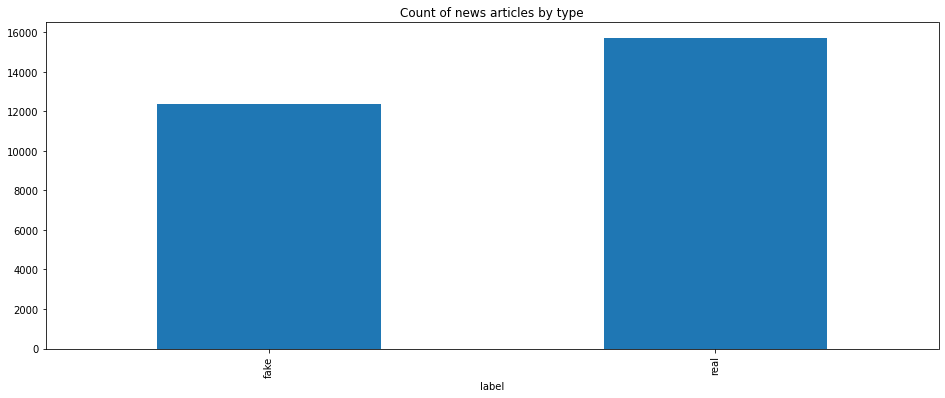

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.xticks(rotation=90)
final_dataset.groupby("label").count()['title'].plot.bar(title = "Count of news articles by type", ax = ax)


> **Data Cleaning:**

Removing Stop words, URLs, Alphanumeric characters, punctuations, words of length smaller than 2 words etc. This is done because they do not contribute to provide useful features for training the DL model. 

The words like “and”, “for”, “the” are useless as they appear in almost every observation in the dataset - these are examples of stop words. A generic stop words list for the English vocabulary is provided by NLTK (the Natural Language Toolkit), which is a suite of libraries and programs for symbolic and statistical natural language processing.

Tokenization is the process of splitting a string into a list of strings (or “tokens”).

In [ ]:
def clean_text(text):
    #URLs do not give any information
    text = re.sub(r"http\S+", "", text)

    #Regex Tokenization
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)

    #Non alphanumerica characters removal
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words

#Data Tokenization
def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens

# Useless Words
useless_words = nltk.corpus.stopwords.words('english') + list(string.punctuation)

corpus_text = [clean_text(i) for i in final_dataset[final_dataset['label'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text1 = [clean_text(i) for i in final_dataset[final_dataset['label'] == 'real']['title'].tolist()]
corpus_text1 = [item for sublist in corpus_text1 for item in sublist]
corpus_text1 = [w.lower().strip() for w in corpus_text1 if w.lower().strip() not in useless_words ]
c1 = Counter(corpus_text1)
most_common_truth = c1.most_common(20)

MOST FREQUENTLY OCCURRING WORDS in the TITLES of News Articles of the dataset:

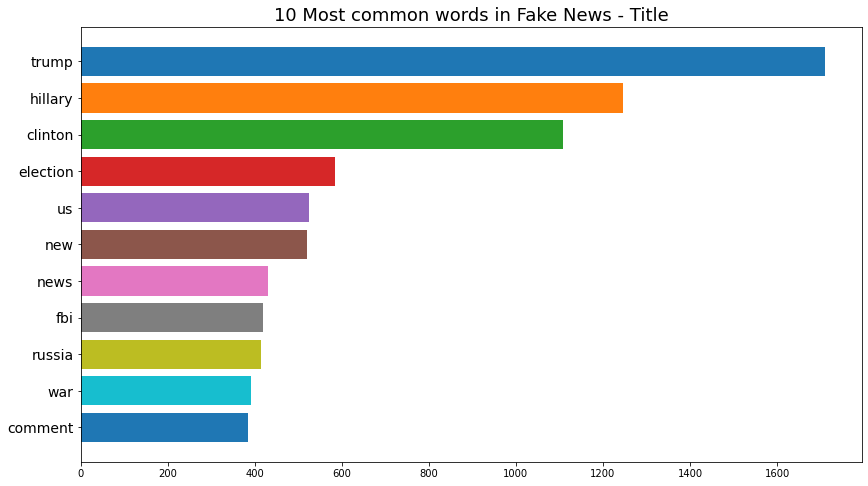

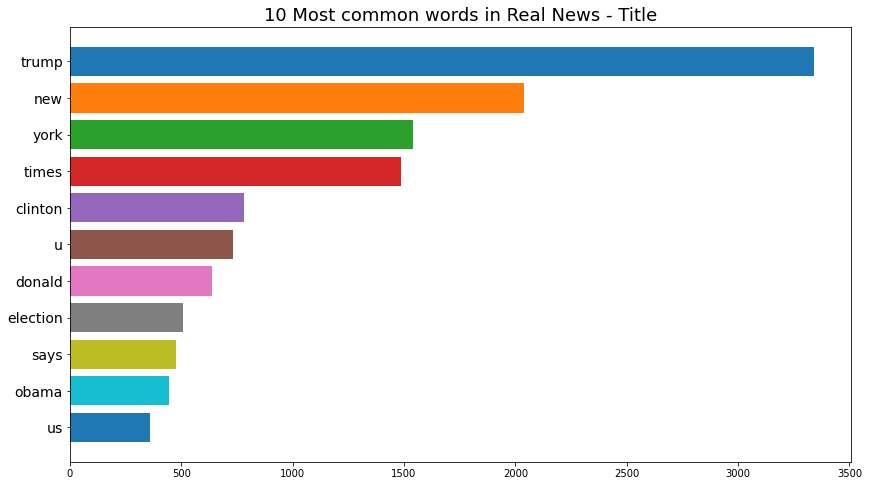

In [ ]:
names = ["10 Most common words in Fake News - Title", "10 Most common words in Real News - Title"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

* Fake news uses the same words more frequently in their titles

**string.punctuation** : Function that provides a list of punctuation characters, we use string translation to replace all punctuation with nothing

In [ ]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# Join title and content columns
all_text = final_dataset.title.str.cat(final_dataset.content, sep=' ')

#start time
t1 = time.time()

# Tokenize using NLTK tokenizer
words = nltk.word_tokenize(" ".join(all_text.tolist()))

In [ ]:
# Useless words removal

# gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
# sklearn_stopwords = stop_words.ENGLISH_STOP_WORDS
# combined_stopwords = sklearn_stopwords.union(nltk_stopwords,gensim_stopwords)

useless_words = nltk.corpus.stopwords.words('english') + list(string.punctuation)

#data clean
cleanwords = [i for i in words if i not in useless_words and i.isalpha() and len(i) > 2]

#some papers suggest lowercasing might removing hidden meaning from news, so not useful - we dont apply here
#cleanwords = cleanwords.lower()

t2 = time.time()
print("Time to clean and tokenize", len(final_dataset), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 28069 articles: 4.343846940994263 min


* It takes quite a long time to clean the content as a whole. 

We will try to understand the dataset further to find out meaningful inferences

**DATASET WORDCLOUD**

A nice way to visualize the same information is with a word cloud where the frequency of each tag is shown with **font size** and **color**.

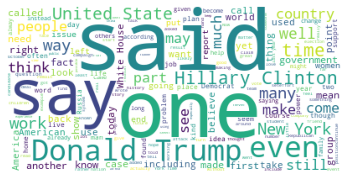

In [ ]:
wordcloud2 = WordCloud( stopwords=STOPWORDS, background_color='white'
                         ).generate(" ".join(cleanwords))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

hilary clinton, donald trump and united states are clearly the most common

But this does not tell us any insight into optimization of our model

### Bigrams

Until now we performed feature engineering by analyzing and processing the whole text. We now look at significance of single words by computing the n-grams frequency. 

An n-gram is a contiguous sequence of n items from a given sample of text. When the n-gram has the size of 1 is referred to as a unigram (size of 2 is a bigram). Hence, if there are n-grams that appear only in one category (i.e “Republican” in Politics news), those can become new features.

In [ ]:
#to analyze data further
bigrams = nltk.bigrams(cleanwords)
counter = Counter(bigrams)
print("BIGRAMS :")
print(counter.most_common(10))

BIGRAMS :
[(('Donald', 'Trump'), 19557), (('Hillary', 'Clinton'), 15107), (('United', 'States'), 13172), (('New', 'York'), 11667), (('White', 'House'), 7059), (('York', 'Times'), 4557), (('The', 'New'), 3602), (('years', 'ago'), 3386), (('President', 'Obama'), 3216), (('Washington', 'Post'), 3143)]


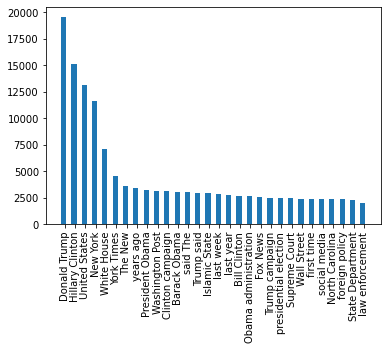

In [ ]:
num = 30
labels = [" ".join(e[0]) for e in counter.most_common(num)]
values = [e[1] for e in counter.most_common(num)]

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width) #use barh & remove rotation 90 
plt.xticks(indexes + width * 0.2, labels, rotation=90)

plt.show()

In [ ]:
# 36 mins!!
# #Function to tokenize sentences - https://www.kaggle.com/ktattan/fake2vec 
# # # tokenize - https://www.kaggle.com/mhamini/fake-news-v3
# # lmtzr = WordNetLemmatizer()
# # texts = [[lmtzr.lemmatize(word) for word in text ] for text in texts]

# def sent_tokenizer(text):
#     text = nltk.sent_tokenize(text)
#     return text

# #Function to lower case remove all websites, emails and non alphabetical characters
# def clean_text(text):
#     #text = [w.strip() for w in text.readlines()]
#     #text.decode('unicode_escape').encode('ascii','ignore')
#     #text = text.decode("utf8")
#     text = str(text)
#     text =  text.split()
#     sentence = []
#     for word in text:
#       #some papers suggest lowercasing might removing hidden meaning from news, so not useful
#       #word = word.lower()
#       #word = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", word) - already done
#       #word = re.sub("[^a-z ]", "", word)
#       #word = nltk.word_tokenize(word)
#       # exclude 1 letter words
#       #word = [w for w in word if len(w)>1] 

#       if word in stops:
#         continue
#       try: 
#         sentence.append(ps.stem(word))
#       except UnicodeDecodeError:
#         sentence.append(word)
#     text = " ".join(sentence)
#     return text.lower()

# def apply_all(text):
#     return clean_text(sent_tokenizer(text))

# #Process data - Stopword removal
# stops = set(stopwords.words("english"))
# #Process data - Stemming: having --> have; friends --> friend
# ps = PorterStemmer()

# #final_dataset.label = final_dataset.label.map(dict(real=1, fake=0))
# final_dataset

# X_cleaned_train[0]
# X_cleaned_test[0]
#X_cleaned_train.describe()
#X_cleaned_test.describe()

# import time
# t1 = time.time()
# final_dataset['sent_tokenized_text'] = final_dataset['content'].apply(apply_all)
# t2 = time.time()
# print("Time to clean and tokenize", len(final_dataset), "articles:", (t2-t1)/60, "min")
# final_dataset.head()
# # create a list of all words using list comprehension
# all_words = [word for item in list(final_dataset['sent_tokenized_text']) for word in item]
# all_words = [subitem for item in all_words for subitem in item]
# final_dataset['sent_tokenized_text']

### Trigrams - Title

We apply RegExp Tokenization & Count Vectorization technique here.

CountVectorizer from Scikit-learn is one of the most popular libraries for machine learning in Python. This vectorizer converts a collection of text documents to a matrix of token counts.

In [ ]:
def clean_text1(text):
    #URLs removal
    text = re.sub(r"http\S+", "", text)

    #Text Tokenization
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)

    #Non alphanumerical characters removal
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)

In [ ]:
#Reduced to half the no of rows so that it doesnt take very long
reduced_dataset = final_dataset.head(15000)

**ngrams : Fake**

In [ ]:
# corpus_text = [clean_text1(i) for i in final_dataset[final_dataset['label'] == 'fake']['title'].tolist()]
# corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]

# c_vec = CountVectorizer(ngram_range=(3,3))
# ngrams = c_vec.fit_transform(corpus_text)

# # needs to happen after fit_transform()
# vocab = c_vec.vocabulary_

# count_values = ngrams.toarray().sum(axis=0)

# # save n-grams
# ngrams_fake = {}
# i=0
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     i+=1
#     if i>30:
#         break
#     ngrams_fake[ng_text] = ng_count

In [ ]:
corpus_text = [clean_text1(i) for i in reduced_dataset[reduced_dataset['label'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [ ]:
print("TRIGRAMS : FAKE")
ngrams_fake

TRIGRAMS : FAKE


{'america finest news': 99,
 'at standing rock': 32,
 'chart of the': 37,
 'clinton email investigation': 19,
 'comment on the': 18,
 'daily contrarian reads': 21,
 'dakota access pipeline': 44,
 'endingfed news network': 37,
 'fbi email investigation': 18,
 'finest news source': 99,
 'hillary clinton and': 19,
 'hillary clinton is': 36,
 'need to know': 20,
 'new eastern outlook': 44,
 'november daily contrarian': 18,
 'of hillary clinton': 24,
 'of the day': 46,
 'onion america finest': 99,
 'paul craig roberts': 26,
 'russia news now': 63,
 'syrian war report': 25,
 'the deep state': 19,
 'the end of': 20,
 'the onion america': 99,
 'the united states': 33,
 'the white house': 21,
 'this is what': 18,
 'to know about': 22,
 'war report november': 19,
 'you need to': 20}

* Fake news generally contains eye catching **phrases** like - america finest news, finest news source, chart of the, comment on the, you need to know etc.
* **Topics** to grab the attention during the election period were seen: clinton email investigation, dakota access pipeline, paul craig roberts, syrian war report, the white house, russian news now etc.

**ngrams : Real**

In [ ]:
# corpus_text1 = [clean_text1(i) for i in final_dataset[final_dataset['label'] == 'real']['title'].tolist()]
# corpus_text1 = [w.lower().strip() for w in corpus_text1 if w.lower().strip() not in useless_words ]

# c_vec1 = CountVectorizer(ngram_range=(3,3))
# ngrams1 = c_vec1.fit_transform(corpus_text1)

# # needs to happen after fit_transform()
# vocab1 = c_vec1.vocabulary_

# count_values1 = ngrams1.toarray().sum(axis=0)

# # save n-grams
# ngrams_real = {}
# i=0
# for ng_count, ng_text in sorted([(count_values1[i],k) for k,i in vocab1.items()], reverse=True):
#     i+=1
#     if i>30:
#         break
#     ngrams_real[ng_text] = ng_count

In [ ]:
corpus_text1 = [clean_text1(i) for i in reduced_dataset[reduced_dataset['label'] == 'real']['title'].tolist()]
corpus_text1 = [w.lower().strip() for w in corpus_text1 if w.lower().strip() not in useless_words ]

c_vec1 = CountVectorizer(ngram_range=(3,3))
ngrams1 = c_vec1.fit_transform(corpus_text1)

# needs to happen after fit_transform()
vocab1 = c_vec1.vocabulary_

count_values1 = ngrams1.toarray().sum(axis=0)

# save n-grams
ngrams_real = {}
i=0
for ng_count, ng_text in sorted([(count_values1[i],k) for k,i in vocab1.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_real[ng_text] = ng_count

In [ ]:
print("TRIGRAMS : REAL")
ngrams_real

TRIGRAMS : REAL


{'at the new': 35,
 'briefing the new': 87,
 'cnn student news': 10,
 'dies at the': 31,
 'donald trump the': 8,
 'donald trump your': 8,
 'election the new': 9,
 'evening briefing the': 44,
 'friday evening briefing': 11,
 'it the new': 13,
 'monday briefing the': 8,
 'monday evening briefing': 10,
 'morning briefing the': 7,
 'new york times': 1433,
 'of the world': 7,
 'say the new': 12,
 'says the new': 15,
 'secretary of state': 7,
 'the new york': 1432,
 'trump the new': 13,
 'tuesday briefing the': 10,
 'wednesday briefing the': 8,
 'wednesday evening briefing': 10,
 'your friday evening': 11,
 'your monday briefing': 8,
 'your monday evening': 10,
 'your morning briefing': 7,
 'your tuesday briefing': 10,
 'your wednesday briefing': 8,
 'your wednesday evening': 10}

* The Real News articles report facts, therefore their trigrams here are mostly jpurnalistic reporting **phrases** like: evening breifing news, your morning briefing, your friday evening, at the new, your monday briefing etc.  

* Trigrams like the new york, new york times, cnn student news etc. are **USA centric** news - as this dataset is based on their experiences and articles

* This further goes on to show that more diverse datasets need to be publicly made on open source platforms to make an impact worldwide

**MOST frequently used tri-grams in the TITLE** of News Articles of this dataset



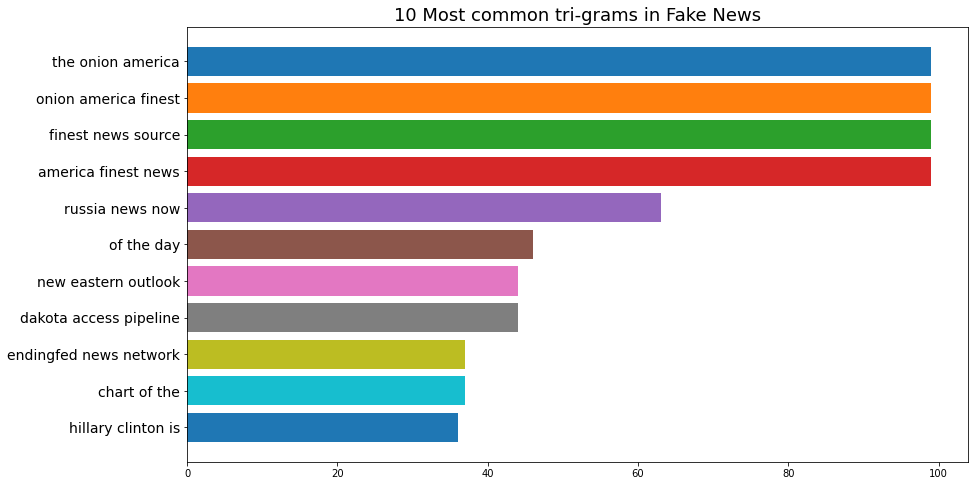

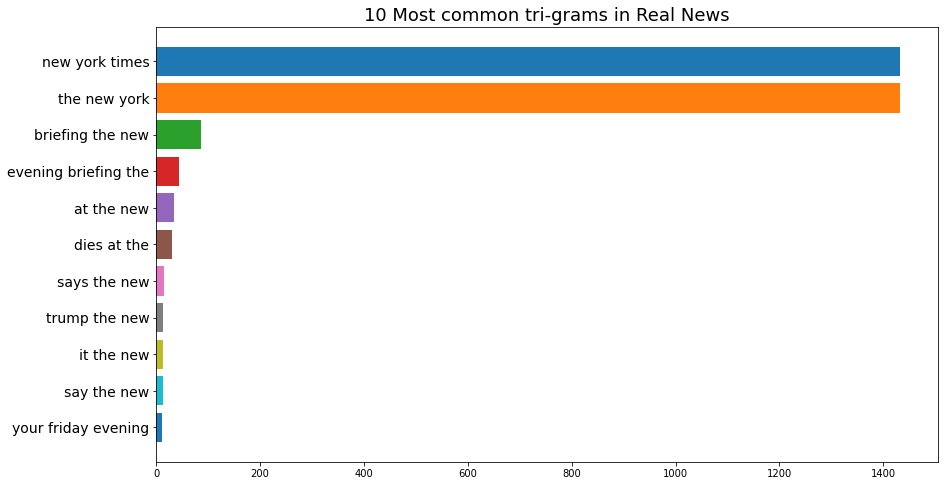

In [ ]:
names = ["10 Most common tri-grams in Fake News - title", "10 Most common tri-grams in Real News - title"]
variables = [ngrams_fake, ngrams_real]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

* This interestingly shows that FAKE News article tend to contain more no of trigrams. 
* Mostly because most of them are based of conspiracy and hearsay.
* While Real News articles are written by reliable sources who are reporting facts. Thus the trigrams here are mostly reporting language like: new york times, evening breifing news, your friday evening, at the new wtc. 
* We also infer that most of the Real news articles refer to New York times - as it clearly is well-known established news corporation, with no bias

**TITLE - TYPE WORDCLOUDS**

In [ ]:
# fig, ax = plt.subplots(2,1, figsize=(16,16))

# corpus_text = ''.join(final_dataset[final_dataset['label'] == 'fake']['title'].tolist())
# wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
# ax[0].imshow(wordcloud, interpolation='bilinear')
# ax[0].axis("off")
# ax[0].set_title(" 'Fake' news articles WordCloud")

# corpus_text = ''.join(final_dataset[final_dataset['label'] == 'real']['title'].tolist())
# wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
# ax[2].imshow(wordcloud, interpolation='bilinear')
# ax[2].axis("off")
# ax[2].set_title(" 'Real' news articles WordCloud")

# plt.tight_layout()

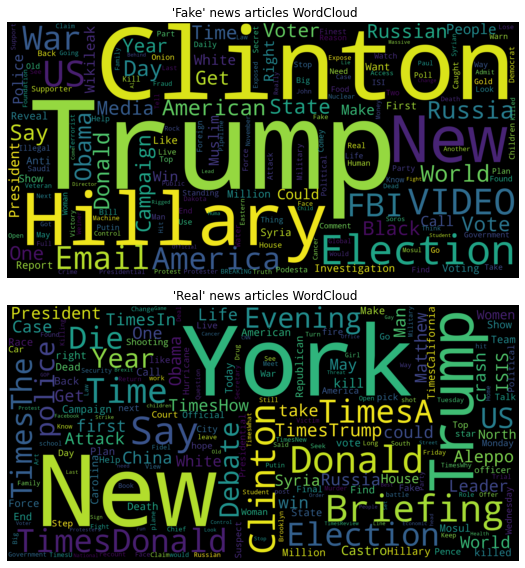

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,8))

corpus_text = ''.join(reduced_dataset[reduced_dataset['label'] == 'fake']['title'].tolist())
wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title(" 'Fake' news articles WordCloud")

corpus_text = ''.join(reduced_dataset[reduced_dataset['label'] == 'real']['title'].tolist())
wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title(" 'Real' news articles WordCloud")

plt.tight_layout()

* Titles of Fake labelled News corpus, is more dominated by few repeatedly used words compared to the Real labelled News corpus. (see the length of the words)

* Fake news is more dominated by Trump and Clinton news, while Real News have more datas oriented words rather than just catchy words

### Trigram - Content

In [ ]:
corpus_text = [clean_text(i) for i in final_dataset[final_dataset['label'] == 'fake']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text1 = [clean_text(i) for i in final_dataset[final_dataset['label'] == 'real']['content'].tolist()]
corpus_text1 = [item for sublist in corpus_text1 for item in sublist]
corpus_text1 = [w.lower().strip() for w in corpus_text1 if w.lower().strip() not in useless_words ]
c1 = Counter(corpus_text1)
most_common_real = c1.most_common(20)

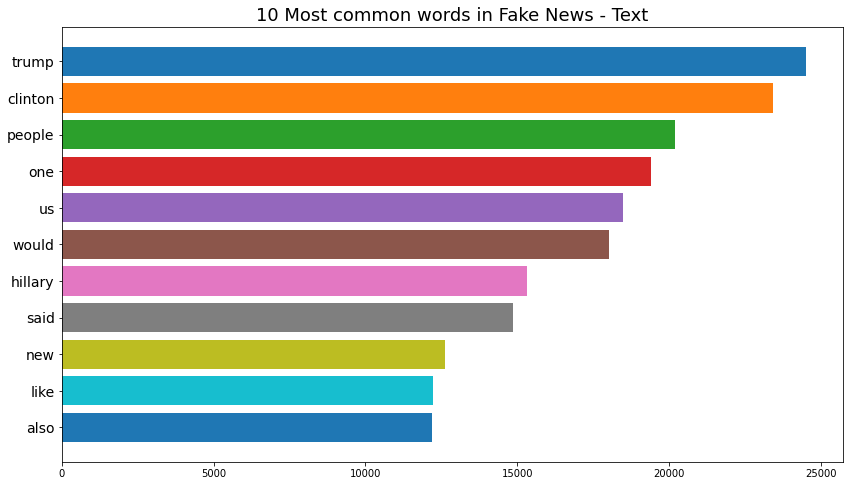

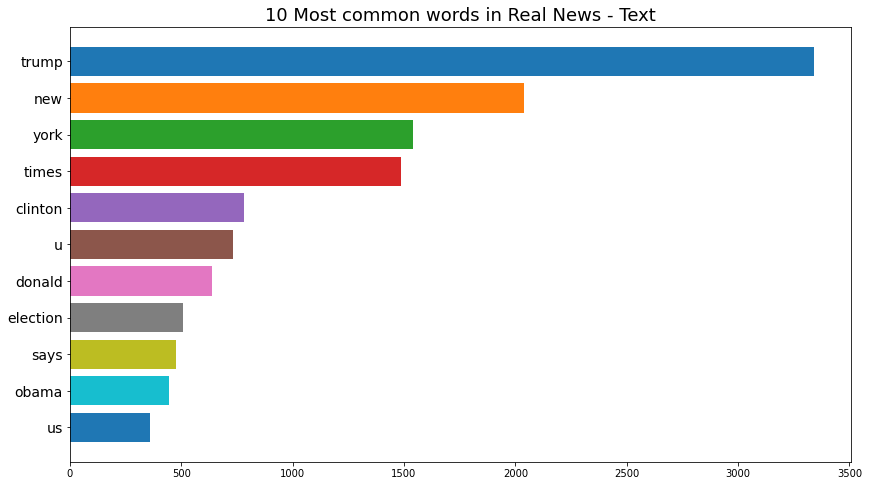

In [ ]:
names = ["10 Most common words in Fake News - Text", "10 Most common words in Real News - Text"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

* It can be infered that even though there are more variety of rral news articles, fake news tend to revolve around the same topics and use same common words evertime - due to lack of originality and uniqueness

**Common Wordcloud**

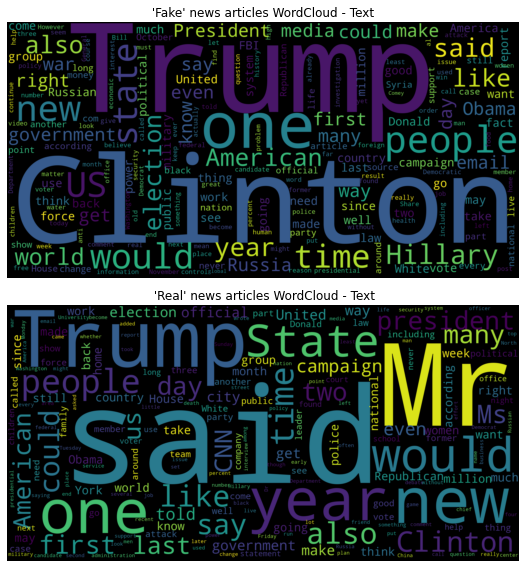

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,8))

corpus_text = ''.join(reduced_dataset[reduced_dataset['label'] == 'fake']['content'].tolist())
wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title(" 'Fake' news articles WordCloud - Text ")

corpus_text = ''.join(reduced_dataset[reduced_dataset['label'] == 'real']['content'].tolist())
wordcloud = WordCloud(stopwords=useless_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title(" 'Real' news articles WordCloud - Text")

plt.tight_layout()

* Article Text of Fake labelled News corpus, is more dominated by few repeadly used words compared to the Real labelled News corpus. (see the length of the words)

**Trigrams**

**MOST frequently used tri-grams in the TEXT** of News Articles of this dataset

In [ ]:
# #Reduced no of rows so that it doesnt take very long
# reduced_dataset = final_dataset.head(1000)

In [ ]:
# corpus_text = [clean_text1(i) for i in reduced_dataset[reduced_dataset['label'] == 'fake']['content'].tolist()]
# corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]

# c_vec = CountVectorizer(ngram_range=(3,3))
# ngrams = c_vec.fit_transform(corpus_text)

# # needs to happen after fit_transform()
# vocab = c_vec.vocabulary_

# count_values = ngrams.toarray().sum(axis=0)

# # save n-grams
# ngrams_fake = {}
# i=0
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     i+=1
#     if i>30:
#         break
#     ngrams_fake[ng_text] = ng_count

In [ ]:
# corpus_text = [clean_text1(i) for i in reduced_dataset[reduced_dataset['label'] == 'real']['content'].tolist()]
# corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in useless_words ]

# c_vec = CountVectorizer(ngram_range=(3,3))
# ngrams = c_vec.fit_transform(corpus_text)

# # needs to happen after fit_transform()
# vocab = c_vec.vocabulary_

# count_values = ngrams.toarray().sum(axis=0)

# # save n-grams
# ngrams_true = {}
# i=0
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     i+=1
#     if i>30:
#         break
#     ngrams_true[ng_text] = ng_count

**CONTENT-TYPE PLOT**

In [ ]:
# names = ["10 Most common tri-grams in Fake News - Text", "10 Most common tri-grams in Real News - Text"]
# variables = [ngrams_fake, ngrams_true]

# for title, var in zip(names, variables):
#     fig, ax = plt.subplots(figsize=(14,8))
#     idx = 0
#     for index, item in var.items():
#         if idx > 10: break
#         ax.barh(width=item, y=index)
#         ax.invert_yaxis()
#         idx += 1
#     plt.tick_params(axis='y', which='major', labelsize=14)
#     plt.title(title, fontsize=18)
#     plt.show()

* Inference: most of the Real news articles refer to New York times - as it clearly is well-known established news corporation, with no bias
* This also shows a key factor that - majority of the REAL articles cite other reliables in their Text - as a way of confiring and relieving the reader that the news they are reading is true.

### Article Length Analysis

It’s important to look at the length of the news article text because it can give a lot of insights. Maybe, for instance, we discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. 

Mostly, this won’t be the case as news articles have similar lengths, but it’s worth a try.

We have tried wordclouds and n grams before - now we try average sentence length technique

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


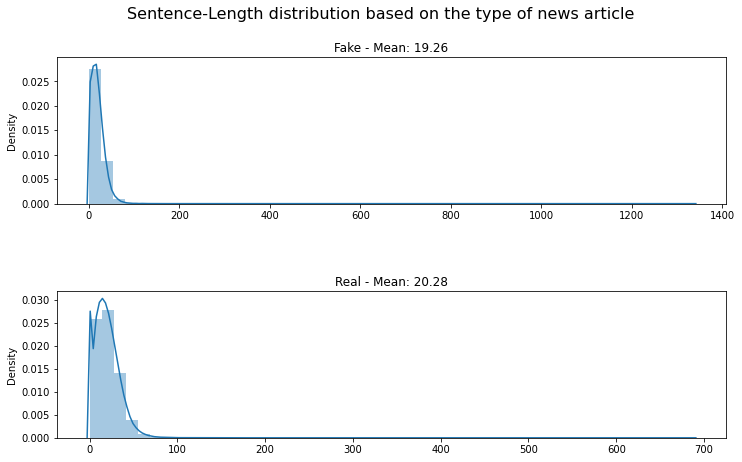

In [ ]:
def split_phrases(text):
    #URL removal
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

corpus_text = '. '.join([i for i in final_dataset[final_dataset['label'] == 'fake']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in final_dataset[final_dataset['label'] == 'real']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

#subplot
fig, ax = plt.subplots(2,1, figsize=(12,7))
fig.suptitle("Sentence-Length distribution based on the type of news article", size=16)

sns.distplot(lengths_fake, ax=ax[0])
ax[0].set_title("Fake - Mean: {0:.2f}".format(np.average(lengths_fake)))

sns.distplot(lengths_truth, ax=ax[1])
ax[1].set_title("Real - Mean: {0:.2f}".format(np.average(lengths_truth)))

fig.subplots_adjust(hspace=0.6)
plt.show()

This seaborn visualization method shows the histogram distribution of data for a single column.



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


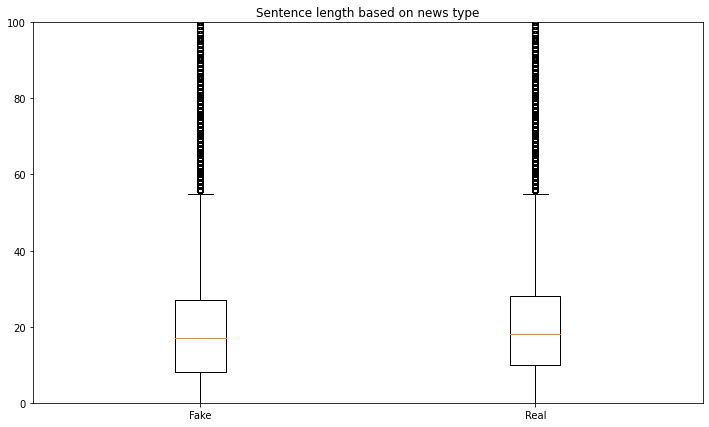

In [ ]:
#Boxplot
fig, ax = plt.subplots(1,1, figsize=(12,7))
plt.title("Sentence length based on news type")
plt.ylim((0,100))
plt.boxplot([lengths_fake, lengths_truth], 
            labels=['Fake', 'Real'])
plt.show()

* we observe that there is no clear relation with type and length of the article. So we cannot just prune articles based on the outlier analysis as content and words clearly mean something based on the previous feature analysis results

### Psychological analysis

Now we analyze the news by usage in terms of:
* First person: *I, me, my, myself, our, we, us*
* Second person: *you, your, yours, yourself*
* Third person: *her, she, hers, he, his, him, they, their, them, theirs*

In [ ]:
def count_person_forms(text, person):
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter

first_person = ["i", "me", "mine", "our", "ours", "we", "us"]
second_person = ["you", "your", "yours"]
third_person = ["he", "she", "hers","her","his","him","they","their","them","theirs"]

In [ ]:
#data parallelization
%pip install pandarallel
from pandarallel import pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.3-py3-none-any.whl size=18402 sha256=b5f076ada4869c1ccc91fbcf2a1ec8679928683fa4f9af8099ca44683da5dc40
  Stored in directory: /root/.cache/pip/wheels/7a/0b/00/8152ea5a7b1b6041fed9881a22fc557974c59e886b8d0460d0
Successfully built pandarallel


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


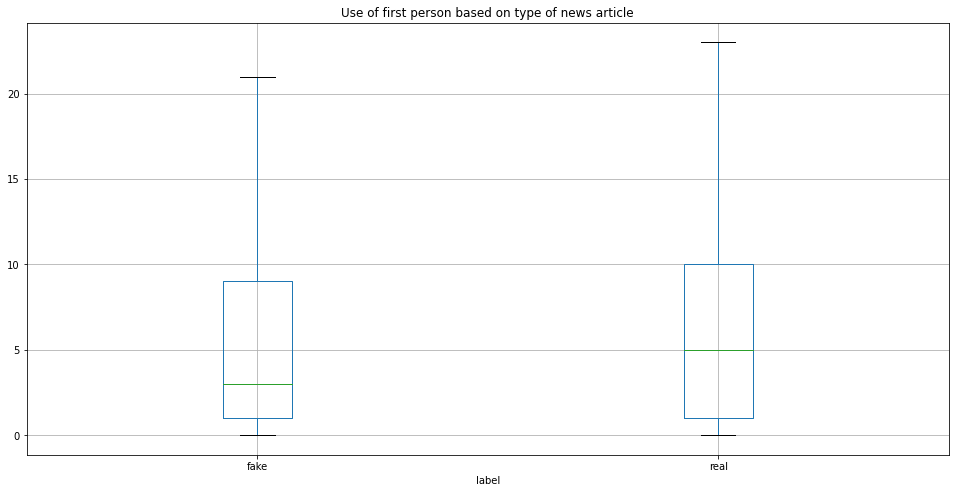

In [ ]:
pandarallel.initialize()

final_dataset['first_person'] = final_dataset.parallel_apply(lambda row: count_person_forms(row['content'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
final_dataset.boxplot(column=['first_person'], by='label', ax=ax, showfliers=False)
ax.set_title("Use of first person based on type of news article")
fig.suptitle("")
plt.show()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


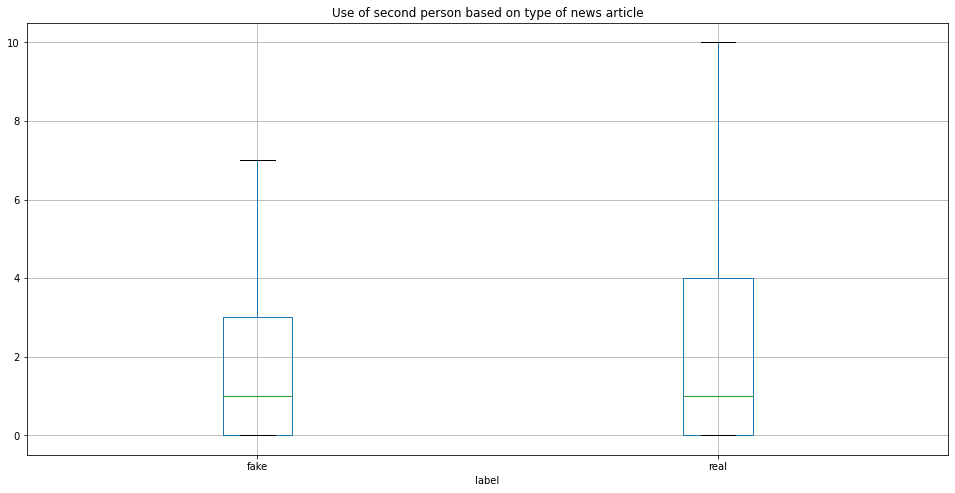

In [ ]:
pandarallel.initialize()
final_dataset['second_person'] = final_dataset.parallel_apply(lambda row: count_person_forms(row['content'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
final_dataset.boxplot(column=['second_person'], by='label', ax=ax, showfliers=False)
ax.set_title("Use of second person based on type of news article")
fig.suptitle("")
plt.show()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


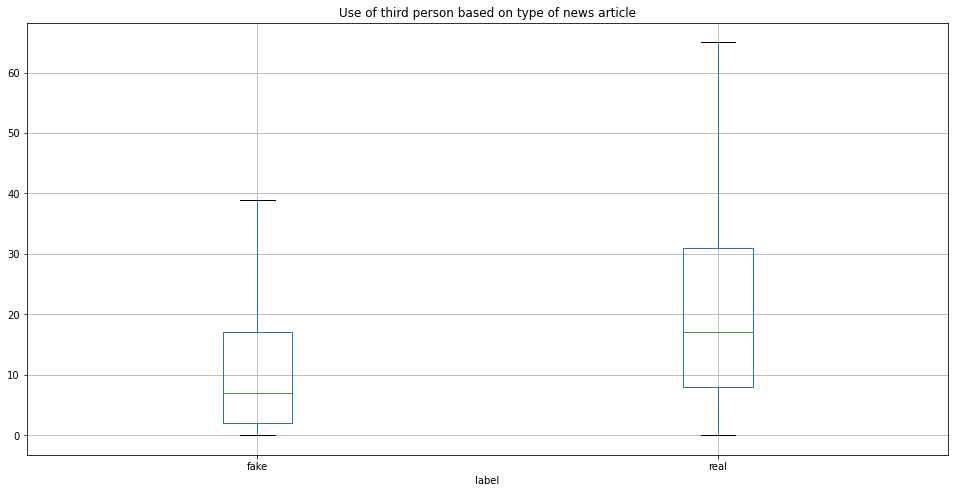

In [ ]:
pandarallel.initialize()
final_dataset['third_person'] = final_dataset.parallel_apply(lambda row: count_person_forms(row['content'], third_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
final_dataset.boxplot(column=['third_person'], by='label', ax=ax, showfliers=False)
ax.set_title("Use of third person based on type of news article")
fig.suptitle("")
plt.show()

In [ ]:
final_dataset.groupby('label')['first_person'].mean()

label
fake     8.735615
real    11.011965
Name: first_person, dtype: float64

In [ ]:
final_dataset.groupby('label')['second_person'].mean()

label
fake    4.034151
real    3.708376
Name: second_person, dtype: float64

In [ ]:
final_dataset.groupby('label')['third_person'].mean()

label
fake    13.366837
real    25.322556
Name: third_person, dtype: float64

* Few articles use first person - especially Fake News articles
* Very few articles use second person - mainly Real/True News articles
* Majority articles are written in thrid person - most of them real news articles by a large margin

### Sentiment Analysis

Sentiment analysis is to understand what sentiment analysis is and how it works.It is the representation of subjective emotions of text data through numbers or classes. Given the fact thatwe had 9 types of fake news present originally in the fake news dataset, calculating sentiment is one of the toughest tasks of NLP as natural language is full of ambiguity. 

A model could assign a positive signal to the word “good” and a negative one to the word “bad”, resulting in a neutral sentiment. That happens because the context is unknown.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def classify_sentiment(text):
    sentim = SentimentIntensityAnalyzer()
    #based on research papers - blank spaces need to be removed
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #URL removal
    text = re.sub(r"http\S+", "", text)
    pol = sentim.polarity_scores(text)['compound']
    return pol

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


As our corpus was originally comprises of online news, Vader (Valence aware dictionary and sentiment reasoner) which is a rule-based model that works particularly well on this social media data.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


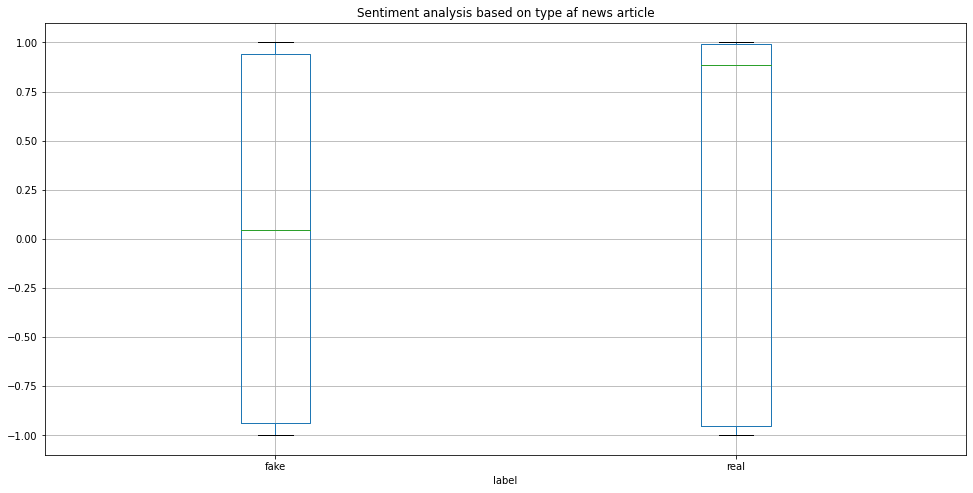

In [ ]:
# took 11 mins - DO NOT RUN AGAIN
import nltk
nltk.download('vader_lexicon')

pandarallel.initialize()
final_dataset['sentiment'] = final_dataset.parallel_apply(lambda r: classify_sentiment(r['content']), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
final_dataset.boxplot(column=['sentiment'], by='label', ax=ax, showfliers=False)
ax.set_title("Sentiment analysis based on type af news article")
fig.suptitle("")
plt.show()

* There is a reliable difference in the sentiment of fake and real news articles
* By looking at the mean figure itself - we can clearly say that majority of real news articles have positive sentiments (extremely close to 1)
* Hence Real labelled News articles have more positive words becuase they are longer becuase they are more positive.
* The fake news articles have significantly lower/negative sentiment (nearly value 0)

### Lexical Analysis

Lexical words are words such as nouns, adjectives, verbs, and adverbs that convey meaning in a text.

LD or "lexical diversity" is a measurement of how many different lexical words there are in a text. Its considered to be an important indicator of how complex and difficult to read a text is. 

LD can tell us about the user's language - their skill with the language (as both native and second language learner) and sometimes also give clues as to their age.

In [ ]:
def lexicaldiversity_analysis(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


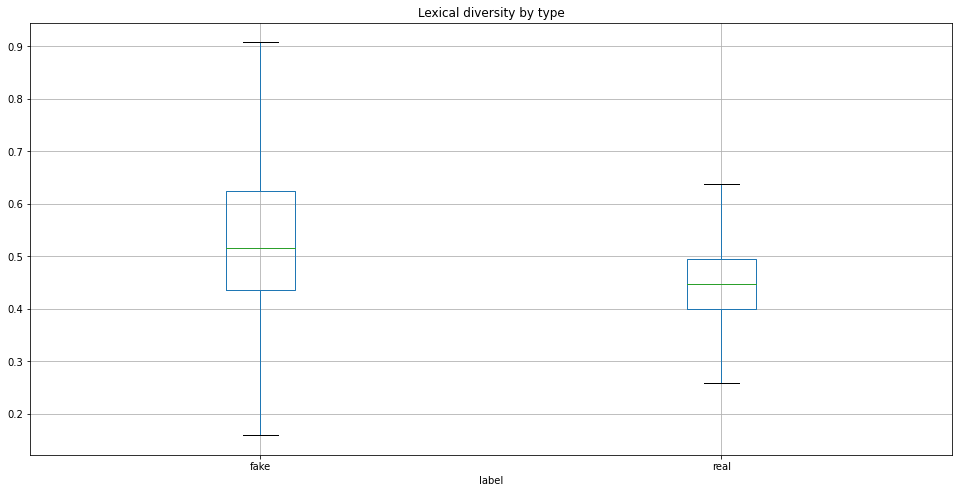

In [ ]:
pandarallel.initialize()
final_dataset['lexical'] = final_dataset.parallel_apply(lambda r: lexicaldiversity_analysis(r['content']), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = final_dataset.boxplot(column=['lexical'], by='label', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

* We see that Fake news articles have significantly more **diversity** than real news articles. Making then deceptive for human to perceive if they are fake or not

Hence, there is a growing need for articles to be automatically detected fake

In [ ]:
final_dataset

,title,content,publication,label,first_person,second_person,third_person,sentiment,lexical
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,fake,0,0,0,0.5267,1.000000
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,fake,2,4,1,-0.9532,0.437220
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,fake,3,2,28,-0.9978,0.507879
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,fake,12,0,7,-0.7783,0.497227
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,fake,1,0,1,0.4449,0.896552
...,...,...,...,...,...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real,3,2,30,-0.9910,0.472222
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real,14,0,6,0.9896,0.444113
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real,0,0,18,0.6918,0.391626
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real,3,2,7,0.9300,0.449351


In [ ]:
final_dataset=final_dataset.drop(['first_person'], axis=1)
final_dataset=final_dataset.drop(['second_person'], axis=1)
final_dataset=final_dataset.drop(['third_person'], axis=1)
final_dataset=final_dataset.drop(['sentiment'], axis=1)
final_dataset=final_dataset.drop(['lexical'], axis=1)

## Training Data: 80-20 Split

In [ ]:
final_dataset

,title,content,publication,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,fake
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,fake
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,fake
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,fake
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [ ]:
final_dataset['label'] = final_dataset['label'].map({'real': 1, 'fake': 0})
final_dataset

,title,content,publication,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,0
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,0
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,0
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,0
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,1


* Performing 80-20 Split on the Final Dataset for training and testing stage

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset['title'], final_dataset.label, test_size=0.2)
# X_cleaned_train = [clean_text(x) for x in X_train]
# X_cleaned_test = [clean_text(x) for x in X_test]

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train.shape)
print("Shape of Dependent training variable, y :",y_train.shape)

print("Shape of Independent test variable, x :",X_test.shape)
print("Shape of Dependent test variable, y :",y_test.shape)

Shape of Independent training variable, x : (22455,)
Shape of Dependent training variable, y : (22455,)
Shape of Independent test variable, x : (5614,)
Shape of Dependent test variable, y : (5614,)


In [ ]:
X_train[0]

0    On The Fault Lines of Change: Globalization-v-...
0    House Republicans Fret About Winning Their Hea...
Name: title, dtype: object

## DNN MODEL



Construct models with TF-IDF Vectorizer for better accuracy.

TFIDF or term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.


In [ ]:
X_train

985      Comment on Residents Fed Up With ‘Overbearing ...
6210     Here’s Who Trump Should Pick for His National-...
5912     Iraqi Christians Hold first mass in over 2 yea...
8955     PSVITA Japan News : Moe Moe World War 3 + Chao...
7734     A Republican Senator Just Told His Fans To Put...
                               ...                        
13238    I thought America was becoming a better place ...
7900     Secret World of US Election: Julian Assange ta...
11401    EU using taxpayer money to give Muslim invader...
15669    More migrants are leaving Germany on their own...
11430    U.S. tentatively approves Delta-Aeromexico ven...
Name: title, Length: 22455, dtype: object

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_features = tfidf_vectorizer.get_feature_names()

In [ ]:
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

neural_network = Sequential()

neural_network.add(Dense(64, input_dim=len(tfidf_features), activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = neural_network.fit(tfidf_train, y_train, epochs=50, batch_size=512, verbose=0)

_,test_acc = neural_network.evaluate(tfidf_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 2)))

Testing Acc. of DNN: 76.95 %


## Training Testing: 70-30 Split

In [ ]:
final_dataset

,title,content,publication,label
0,On The Fault Lines of Change: Globalization-v-...,By Julian Rose Virtually everything that conve...,activistpost,0
1,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets,TRUNEWS 10/27/16 Rob Kirby | Unspoken Secrets ...,trunews,0
2,Fox News’ Bill O’Reilly Calls for All Gun Crim...,"Email \nOn Wednesday evening Bill O’Reilly, ho...",thenewamerican,0
3,Comment on Leaked Audio Catches Clinton Red-Ha...,Home / Be The Change / Government Corruption /...,thefreethoughtproject,0
4,9 Reasons Why I Am NOT Voting,By Chris Duane Chris Duane explains why he’s n...,activistpost,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset['title'], final_dataset.label, test_size=0.3)

# determining the shapes of training and testing sets
print("Shape of Independent training variable, x :",X_train.shape)
print("Shape of Dependent training variable, y :",y_train.shape)

print("Shape of Independent test variable, x :",X_test.shape)
print("Shape of Dependent test variable, y :",y_test.shape)

Shape of Independent training variable, x : (19648,)
Shape of Dependent training variable, y : (19648,)
Shape of Independent test variable, x : (8421,)
Shape of Dependent test variable, y : (8421,)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf_features = tfidf_vectorizer.get_feature_names()

In [ ]:
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

neural_network = Sequential()

neural_network.add(Dense(64, input_dim=len(tfidf_features), activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = neural_network.fit(tfidf_train, y_train, epochs=50, batch_size=512, verbose=0)

_,test_acc = neural_network.evaluate(tfidf_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 2)))

Testing Acc. of DNN: 75.95 %


We use word embeddings, which converts text data, i.e., words into vectors. It represents every word in an n-dimensional dense vector where similar words will have a similar vector. The more efficient word embeddings techniques which have proven there capability to convert words into vectors are GloVe and Word2Vec.


DNN : GloVe word embedding technique has been used to calculate word embeddings using a co-occurrence matrix in between words within fake news tweets, which is called the embedding matrix. The embedding matrix is used to represent the tweets into dense vectors.

RNN: A recurrent neural network is useful
because it allows for the intermediate values (states) to
store information about past inputs for a time that is
not set a priori. The RNN uses
the secret state to store the state of each moment, and
the state depends on the previous moment and current
input. The new secret state effectively capitalizes on
the past knowledge. the gradient descent method is difficult to implement because of the well-known gradient
vanishing/explosion problem [67]. To solve these
two separate issues, research is being performed on
Long Short-Term Memory (LSTM), GRU, etc.

LSTM: It is a deep RNN which is more reliable than the traditional RNN when
used in tasks with long time lags. The main difference
between an RNN and an LSTM is that an RNN has a
single tanh layer, while an LSTM has four interactive
LSTM layers


Though LSTM uses a certain kind of RNN. LSTM
learning techniques are able to learn long term
dependencies. Although LSTM cannot learn to fill
a wide gap in knowledge, RNNs do not have a gap
problem. LSTM minimizes the number of losses.
LSTM embraces character sequences of varying
lengths, such so that no linguistic features are 
needed to be extracted.


GRU: The GRU has the same structure as either a basic
RNN or STM, except the GRU updates the hidden state [71], [72].. The key difference between
LSTM and GRU is that LSTM combines forget and
input layers into a single ‘‘update gate’’, combines
cell state and hidden state, and is more convenient and commo

## CNN MODEL


## RNN MODEL


## LSTM MODEL
